# EEG data examples

Here, we demonstrate `sbijax` using a complicated real world EEG data set. We first load some required libraries and an EEG dataset.

We will take EEG measurements when subjects have their eyes closed or open, respectively, and compute posterior distributions of relevant parameters for each measurement to detect a difference in distributions between the two.

In [1]:
import os
import arviz as az
import jax
import numpy as np
import optax
import pandas as pd
import sbijax
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from jax import numpy as jnp, random as jr
from tensorflow_probability.substrates.jax import distributions as tfd

In [2]:
import mne
import moabb

from jax.scipy.signal import welch
from mne import set_config, get_config
from moabb.datasets import Rodrigues2017

## EEG data

The data set can be readily downloaded using the `moabb` package and preprocessed using the EEG analysis tool `mne`.

In [3]:
mne_pt = "mne_data"
if not os.path.exists(mne_pt):
    os.mkdir(mne_pt)

set_config('MNE_DATASETS_ALPHAWAVES_PATH', mne_pt)
dataset = Rodrigues2017()
dataset.download()

/var/folders/w8/7mc8k9m916qgh982xqxfgsr00000gn/T/ipykernel_51165/2610150450.py:5: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_ALPHAWAVES_PATH"
  set_config('MNE_DATASETS_ALPHAWAVES_PATH', mne_pt)
SHA256 hash of downloaded file: 4369a2bf7766dc16fdea44ce4d70b96448c2a7784ec097deb0d66b57f29438d3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: f178eac0720679bac17e4cc18b7b958d3fbfe81246f45792699a7e0f9b63da8d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 9db2e0f7ff016c8ab0fe5a151f085ddb14a20d3fcd91ee0f9c67f736008d925c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 987e0f2f621b61815516fa9457825

Following previous work (the our manuscript for more information), we filter the data at 3Hz and 40Hz and resample them.

In [4]:
raw = dataset._get_single_subject_data(subject=2)['0']['0']
raw = raw.filter(l_freq=3, h_freq=40, verbose=False)
raw = raw.resample(sfreq=128, verbose=False)

We then extract the EEG recordings from the Oz channel and visualize the data.

In [5]:
events = mne.find_events(raw=raw, shortest_event=1, verbose=False)
event_id = {'closed': 1, 'open': 2}
epochs = mne.Epochs(raw, events, event_id, tmin=0.0, tmax=8.0, baseline=None, verbose=False)
epochs = epochs.load_data().pick_channels(['Oz'])

Using data from preloaded Raw for 10 events and 1025 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [6]:
X_closed = epochs['closed'].get_data().squeeze()
f, S_closed = welch(X_closed, fs=epochs.info['sfreq'], nperseg=64, axis=1)
S_closed_db = 10 * np.log10(S_closed)

X_opened = epochs['open'].get_data().squeeze()
f, S_opened = welch(X_opened, fs=epochs.info['sfreq'], nperseg=64, axis=1)
S_opened_db = 10 * np.log10(S_opened)

In [7]:
if not os.path.exists("figs"):
    os.mkdir("figs")

color_closed = "#700e01"
color_open = "#c79999"

To compute posterior distributions later, we randomly select one sample from the closed-eyes EEGs and one from the open-eyes EEGs.

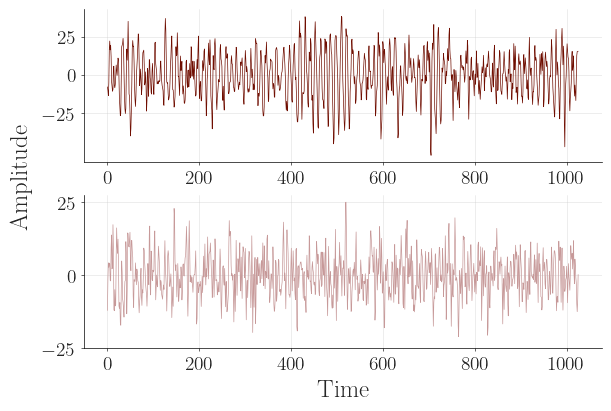

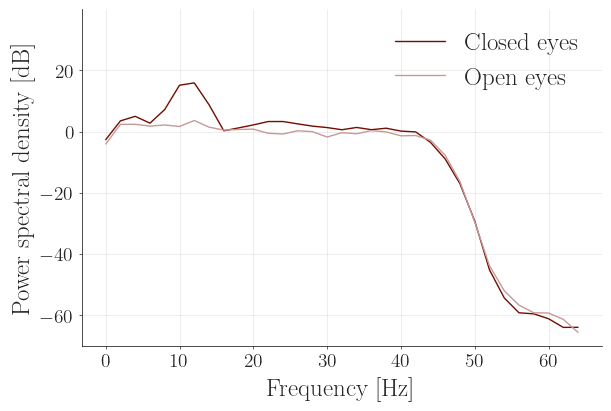

In [8]:
with plt.style.context("sbijax"):        
    fig, laxes = plt.subplots(layout="constrained", figsize=(6, 4), nrows=2)
    laxes[0].plot(X_closed[2, :], color=color_closed, label="closed", linewidth=.5)
    laxes[1].plot(X_opened[2, :], color=color_open, label="opened", linewidth=.5)            
    laxes[0].yaxis.set_ticks([-25, 0, 25])
    laxes[1].yaxis.set_ticks([-25, 0, 25])
    laxes[0].tick_params(axis='both',labelsize=14)
    laxes[1].tick_params(axis='both',labelsize=14)
    laxes[0].grid(linewidth=0.5)
    laxes[1].grid(linewidth=0.5)
    laxes[0].spines['bottom'].set_color('black')    
    laxes[1].spines['bottom'].set_color('black')
    laxes[0].spines['left'].set_color('black')
    laxes[1].spines['left'].set_color('black')
    laxes[1].set_xlabel("Time", fontsize=18)
    laxes[0].set_ylabel("Amplitude", fontsize=18)
    laxes[0].yaxis.set_label_coords(-0.1, -0.1)    
    plt.savefig("figs/real_data-data.pdf", dpi=200)
    plt.show()

with plt.style.context("sbijax"):
    fig, raxes = plt.subplots(layout="constrained", figsize=(6, 4))        
    raxes.plot(f, S_closed_db[2], color=color_closed, lw=1, label="Closed eyes")
    raxes.plot(f, S_opened_db[2], color=color_open, lw=1, label="Open eyes")    
    raxes.yaxis.set_ticks([-60, -40, -20, 0, 20], )
    raxes.set_ylim(-70, 40)
    raxes.spines['bottom'].set_color('black')
    raxes.spines['left'].set_color('black')
    raxes.tick_params(axis='both',labelsize=14)    
    raxes.set_xlabel("Frequency [Hz]", fontsize=18)
    raxes.set_ylabel("Power spectral density [dB]", fontsize=18)
    raxes.legend(frameon=False, fontsize=18)
    raxes.grid(linewidth=0.5)
    plt.savefig("figs/real_data-periodogram.pdf", dpi=200)
    plt.show()

For completeness, we plot the entire data set, too.

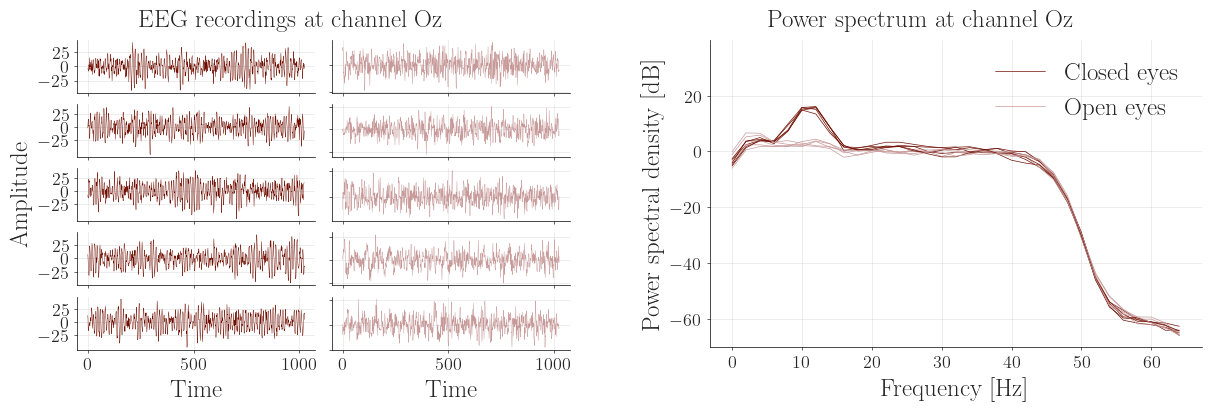

In [9]:
fig = plt.figure(layout="constrained", figsize=(12, 4))
subfigs = fig.subfigures(1, 2, wspace=0.1, width_ratios=[1.5, 1.5])
with plt.style.context("sbijax"):
    subfigs[0].suptitle("EEG recordings at channel Oz", fontsize=18)
    subfigs[1].suptitle("Power spectrum at channel Oz", fontsize=18)
    laxes = subfigs[0].subplots(5, 2)    
    for i in range(5):
        laxes[i, 0].plot(X_closed[i, :], color=color_closed, label="closed", linewidth=.31)
        laxes[i, 1].plot(X_opened[i, :], color=color_open, label="opened", linewidth=.31)        
        if i != 4:
            laxes[i, 0].xaxis.set_ticklabels([])            
            laxes[i, 1].xaxis.set_ticklabels([]) 
        laxes[i, 0].yaxis.set_ticks([-25, 0, 25])
        laxes[i, 1].yaxis.set_ticklabels([])     
        laxes[i, 0].grid(linewidth=0.5)
        laxes[i, 1].grid(linewidth=0.5)
        laxes[i, 0].spines['bottom'].set_color('black')
        laxes[i, 0].spines['left'].set_color('black')
        laxes[i, 1].spines['bottom'].set_color('black')
        laxes[i, 1].spines['left'].set_color('black')
        laxes[i, 0].tick_params(axis='both',labelsize=13)
        laxes[i, 1].tick_params(axis='both',labelsize=13)
    laxes[2, 0].set_ylabel("Amplitude", fontsize=18)
    laxes[4, 0].set_xlabel("Time", fontsize=18)
    laxes[4, 1].set_xlabel("Time", fontsize=18)
    
    raxes = subfigs[1].subplots(1, 1)
    for i in range(5):
        if i ==0:
            raxes.plot(f, S_closed_db[i], color=color_closed, lw=.5, label="Closed eyes")
            raxes.plot(f, S_opened_db[i], color=color_open, lw=.5, label="Open eyes")
        else:
            raxes.plot(f, S_closed_db[i], color=color_closed, lw=.5)
            raxes.plot(f, S_opened_db[i], color=color_open, lw=.5)
    raxes.yaxis.set_ticks([-60, -40, -20, 0, 20])
    raxes.set_ylim(-70, 40)
    raxes.spines['bottom'].set_color('black')
    raxes.spines['left'].set_color('black')
    raxes.set_ylabel("Power spectral density [dB]", fontsize=18)
    raxes.set_xlabel("Frequency [Hz]", fontsize=18)
    raxes.legend(frameon=False, fontsize=18)
    raxes.grid(linewidth=0.5)
    raxes.tick_params(axis='both',labelsize=13)
plt.savefig("figs/real_data-all_data.pdf", dpi=200)
plt.show()

## Prior and simulator

We next set up the prior and simulator. For the simulator, we use the [sdbmpABC](https://github.com/massimilianotamborrino/sdbmpABC) package which neatly implements the Jansen-Rit SDE (unfortunately it is written in R/C++).

In [10]:
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        C=tfd.Uniform(10.0, 250.0),
        mu=tfd.Uniform(50.0, 500.0),
        sigma=tfd.Uniform(100, 5000),
        gain=tfd.Uniform(-20, 20),
    ), batch_ndims=0)
    return prior

prior = prior_fn()

In [11]:
from jrnmm import simulate

In [12]:
def jansen_rit_fn(len_timeseries=1025, t_end=8.0):
    from jrnmm import simulate as simulate_jrnmm
    
    burnin = 0.0
    h = 1 / 128 # sampling rate is 1/F where F=128    
    def fn(seed, theta):
        yt = simulate_jrnmm(
            seed,
            dt=h,
            t_end=t_end + burnin + h,
            initial_states=jnp.array([0.08, 18, 15, -0.5, 0.0, 0.0]),
            Cs=theta['C'],
            mus=theta['mu'],
            sigmas=theta['sigma'],
            gains=theta['gain'],
        )
        yt = yt[:, int(burnin/h):, 0]
        yt = yt - jnp.mean(yt, axis=1, keepdims=True)
        return yt
    
    return fn

simulate_jansen_rit = jansen_rit_fn(len_timeseries=1025, t_end=8.0)

We then construct a simulator suitable for sbijax.

In [13]:
def simulator(seed, theta, len_timeseries=1025, t_end=8.0, batch_size=1_000):
    n = theta['C'].shape[0]    
    seeds = jr.split(seed, n)
    
    ys = []
    n_batches = n // batch_size + int(np.ceil(n % batch_size / batch_size))
    for i in range(n_batches):        
        sl = slice(i * batch_size, (i + 1) * batch_size)
        theta_sub = jax.tree.map(lambda x: x[sl], theta)        
        y = simulate_jansen_rit(seed, theta_sub)
        ys.append(y.astype(jnp.float32))
    ys = jnp.vstack(ys)
    return ys

In a final step before inferring the posteriors, we simulate $100\ 000$ synthetic trajectories. We save them, a reference trjectory for testing, and the real data as a pickle file in order to avoid lengthy computations.

In [14]:
def get_experimental_data(prior, n_simulations=100_000):
    # synthetic data example
    theta_synthetic = dict(zip(['C', 'mu', 'sigma', 'gain'], [135, 220, 2000, 0]))
    y_synthetic = simulate_jansen_rit(jr.PRNGKey(1), theta_synthetic)    

    # experimental data
    y_experimental_closed = X_closed[[4]]
    y_experimental_opened = X_opened[[4]]    

    # simulations    
    theta_train = prior.sample(seed=jr.PRNGKey(0), sample_shape=(n_simulations,))
    y_train = simulator(jr.PRNGKey(1), theta_train)
    
    di = dict(
        theta_synthetic=theta_synthetic, 
        y_synthetic=y_synthetic, 
        y_experimental_closed=y_experimental_closed, 
        y_experimental_opened=y_experimental_opened,
        theta_train=theta_train,
        y_train=y_train
    )
    jax.config.update("jax_enable_x64", False)
    return di

eeg_data = get_experimental_data(prior)

# Summary statistics

As described in the manuscript, we do inference on a collection of summary statistics for which we take the spectral density evaluated at several bins instead of the entire time series.

In [15]:
def summarize(y, n_summaries=33, fs=epochs.info['sfreq']):
    _, summaries = welch(y, fs=fs, nperseg=2 * (n_summaries - 1), axis=1)
    return summaries

In [16]:
summaries_train = summarize(eeg_data["y_train"])

# Neural posterior estimation

We now do posterior inference. We choose to use neural posterior estimation here, but any other method implemented in sbijax would also work. Neural posterior, however, has the advantage that we only have to model a four-dimensional space (i.e., the dimensionality of the posterior) and not the data space, which makes it efficient in this scenario.

We train in an amortized fashion such that we can compute posteriors for multiple observations (i.e., closed vs opened eyes).

Notice that we do not provide the simulator function here. Since we train in an amortized fashion and already have a set of simulated samples, the simulator is not needed here. In many inferential problems in the natural sciences it is common that new data cannot be simulated, but a batch of previously simulated samples is available. sbijax supports this scenario like this as shown below.

In [17]:
from sbijax import NPE
from sbijax.nn import make_maf

In [18]:
n_dim_data = 33 # number of summary statistics from prior literature
n_dim_theta = 4 # posterior dimensionality
n_layers, hidden_sizes = 10, (64, 64)
neural_network = make_maf(n_dim_theta, n_layers, hidden_sizes=hidden_sizes)

fns = prior_fn, None

In [19]:
summaries_train.shape

(100000, 33)

In [20]:
data = {"y": summaries_train, "theta": eeg_data["theta_train"]}
estim = NPE(fns, neural_network, use_event_space_bijections=False)
params, info = estim.fit(
    jr.PRNGKey(1),
    data=data,
    optimizer=optax.adam(0.0001),
    n_early_stopping_delta=0.01,
    n_early_stopping_patience=10,
)

 20%|████████████████████▊                                                                                    | 198/1000 [05:37<22:47,  1.71s/it]


# Synthetic data example

We evaluate first if we are able to approximately infer the true parameter values for a synthetic samples.

In [21]:
posterior_synthetic, _ = estim.sample_posterior(
    jr.PRNGKey(2), 
    params,
    observable=summarize(eeg_data["y_synthetic"].reshape(1, -1)),    
    n_samples=10_000,
)

In [22]:
eeg_data["theta_synthetic"]

{'C': 135, 'mu': 220, 'sigma': 2000, 'gain': 0}

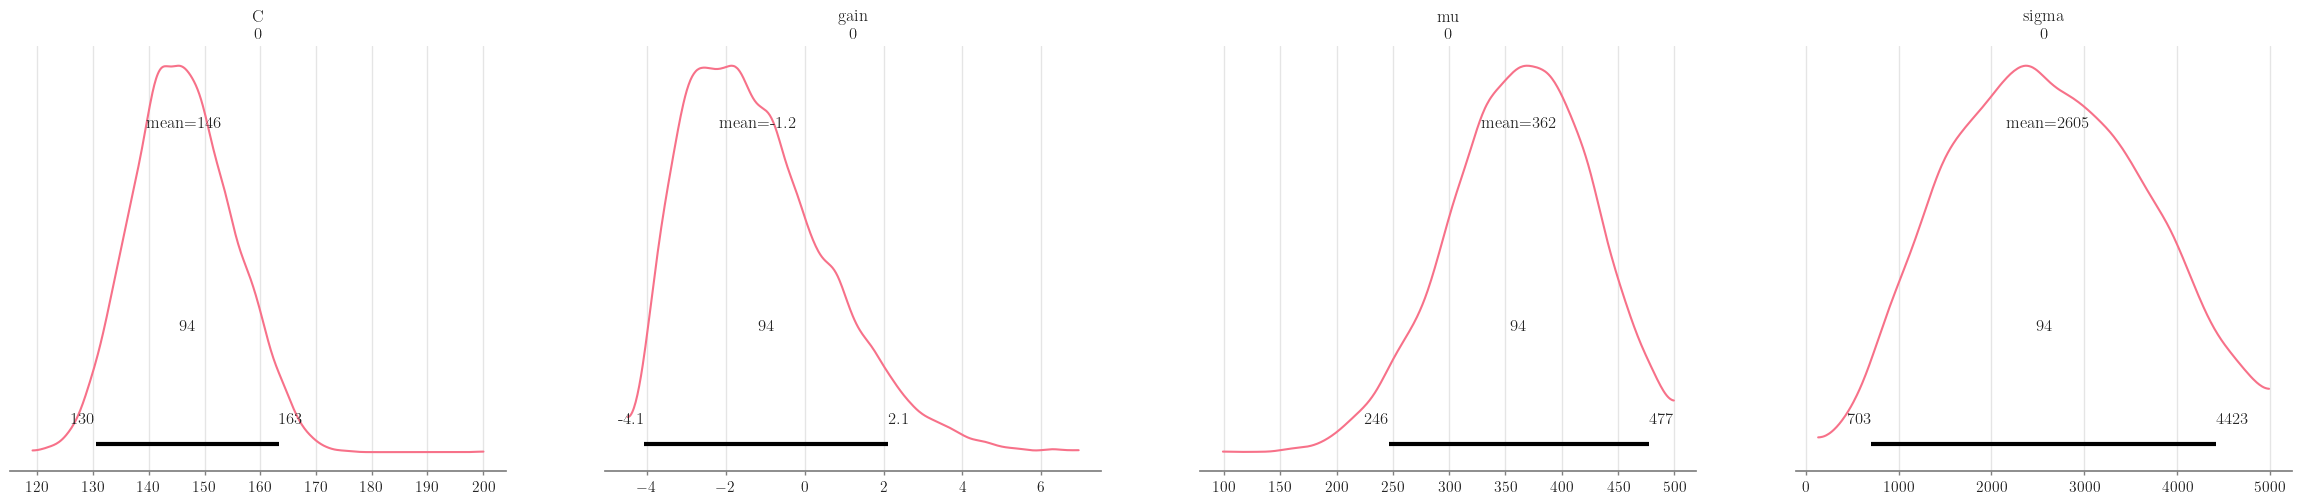

In [23]:
az.plot_posterior(posterior_synthetic)
plt.show()

## Inference of posterior distributions for closed and opened eyes EEG data

We, finally, infer the posterior distributions of EEG data when eyes where closed or openened, respectively. Having an amortized posterior model, we can just plug in different observations and sample from the trained normalizing flow model. For the open eyes state, this might take considerably longer since the data cannot be well described by the simulator model.

In [24]:
posterior_closed, _ = estim.sample_posterior(
    jr.PRNGKey(2), 
    params,
    observable=summarize(eeg_data["y_experimental_closed"]),
    n_samples=10_000
)

In [25]:
posterior_open, _ = estim.sample_posterior(
    jr.PRNGKey(2),
    params,
    observable=summarize(eeg_data["y_experimental_opened"]),
    n_samples=10_000,
)

We convert the inference data to flat dictionaries for ease of plotting, and then visualize the posterior distributions of both eye states.

In [26]:
posterior_open = sbijax.inference_data_as_dictionary(posterior_open.posterior)
posterior_closed = sbijax.inference_data_as_dictionary(posterior_closed.posterior)

In [27]:
symbols = ["$C$", "$\\mu$", "$\\sigma$", "$g$"]
keys = ['C', 'mu', 'sigma', 'gain']

In [28]:
lims = {
    "C": ((0, 250), (100, 200)),
    "mu": ((50.0, 600.0), (200, 400)),
    "sigma": ((0, 5000), (0, 2000, 4000)),
    "gain": ((-25, 25), (-20, 0, 20))
}

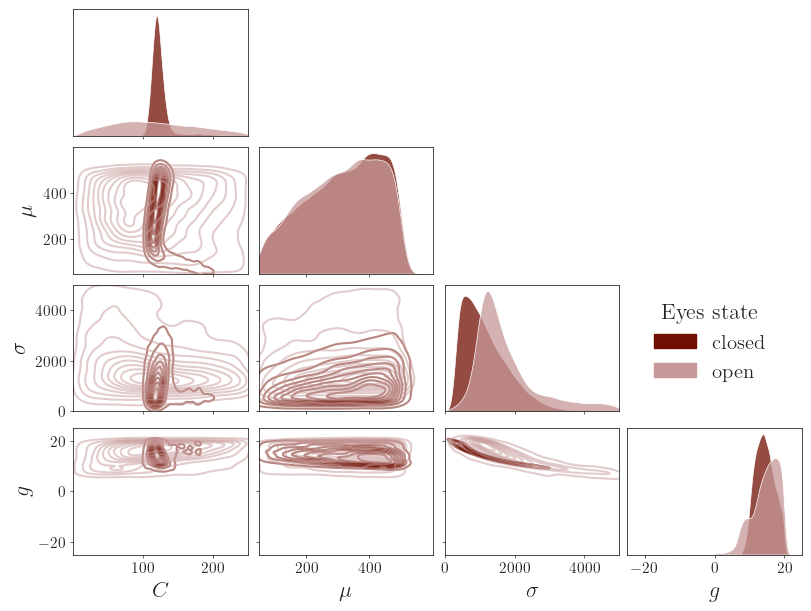

In [29]:
with plt.style.context("sbijax"):
    _, axes = plt.subplots(figsize=(8, 6), nrows=4, ncols=4, layout="constrained")
    for i, key_i in enumerate(keys):
        for j, key_j in enumerate(keys):
            ax = axes[i, j]
            ax.grid(False)
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            ax.spines['right'].set_visible(True)
            ax.spines['right'].set_color('black')
            ax.spines['top'].set_visible(True)
            ax.spines['top'].set_color('black')
            ax.set_ylabel(None)
            ax.set_xlabel(None)
            if i < j:
                ax.axis('off')
            elif i != j:       
                ddf = pd.DataFrame({key_j: np.squeeze(posterior_closed[key_j]), key_i: np.squeeze(posterior_closed[key_i])})
                sns.kdeplot(data=ddf, x=key_j, y=key_i, ax=ax, color=color_closed, alpha=.5)                
                ddf = pd.DataFrame({key_j: np.squeeze(posterior_open[key_j]), key_i: np.squeeze(posterior_open[key_i])})
                sns.kdeplot(data=ddf, x=key_j, y=key_i, ax=ax, color=color_open, alpha=.5)                
                ax.set_ylim(*lims[key_i][0])                
                ax.set_xlim(*lims[key_j][0])
                ax.set_yticks(lims[key_i][1])
                ax.set_xticks(lims[key_j][1])        
                ax.set_xlabel(None)
                ax.set_ylabel(None)
            
                if j == 0:
                    ax.set_ylabel(symbols[i], fontsize=16)
                else: 
                    ax.set_yticklabels([])                
                if i == 3:
                    ax.set_xlabel(symbols[j], fontsize=16)
                else:
                    ax.set_xticklabels([])
            else:
                ddf = pd.DataFrame({key_j: np.squeeze(posterior_closed[key_j])})
                sns.kdeplot(data=ddf, x=key_j, ax=ax, color=color_closed, multiple="stack", linewidth=.5, edgecolor="white", label="Closed eyes")
                ddf = pd.DataFrame({key_j: np.squeeze(posterior_open[key_j])})
                sns.kdeplot(data=ddf, x=key_j, ax=ax, color=color_open, multiple="stack", linewidth=.5, edgecolor="white",label="Open eyes")
                ax.set_xlabel(None)
                ax.set_ylabel(None)
                if i != 3:
                    ax.set_xticklabels([]) 
                ax.set_yticks([])            
                ax.set_yticklabels([])
                if i == 3:
                    ax.set_xlabel(symbols[i], fontsize=16)
                ax.set_xlim(*lims[key_i][0])                
                ax.set_xticks(lims[key_i][1])        
axes[2, 3].legend(
    title="Eyes state",
    handles=[
        mpatches.Patch(color=color_closed, label='closed'),
        mpatches.Patch(color=color_open, label='open'),
    ],
    frameon=False,
    bbox_to_anchor=(0.9, 1),
    fontsize=15,
    title_fontsize=16
)
plt.savefig("figs/real_data-real_data_posteriors.pdf", dpi=200)
plt.show()

## Session info

In [30]:
import session_info

session_info.show(html=False)

-----
arviz                       0.19.0
haiku                       0.0.12
jax                         0.4.31
jaxlib                      0.4.31
jrnmm                       0.1.1.post2
matplotlib                  3.9.2
mne                         1.8.0
moabb                       1.1.1
numpy                       1.26.4
optax                       0.2.4
pandas                      1.5.3
sbijax                      0.3.4
seaborn                     0.12.2
session_info                1.0.0
tensorflow_probability      0.25.0
-----
IPython             8.31.0
jupyter_client      8.6.3
jupyter_core        5.7.2
jupyterlab          4.3.1
-----
Python 3.11.7 (main, Dec  9 2023, 06:06:18) [Clang 14.0.3 (clang-1403.0.22.14.1)]
macOS-13.0.1-arm64-arm-64bit
-----
Session information updated at 2025-02-17 16:39
